<a href="https://colab.research.google.com/github/erikrosen01/LLM-saliency-map/blob/main/LLM_saliency_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2Model

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Ensure the model is in evaluation mode
model.eval()

# Define a sequence of tokens
input_text = "The quick brown fox jumps over the lazy dog"
tokens = tokenizer(input_text, return_tensors='pt')

# Specify the marked token (e.g., "fox")
marked_token = "fox"
marked_token_id = tokenizer.encode(marked_token, add_special_tokens=False)[0]

# Find the position of the marked token in the sequence
marked_token_index = (tokens['input_ids'][0] == marked_token_id).nonzero(as_tuple=True)[0].item()

# Get the embeddings for the input tokens
embeddings = model.wte(tokens['input_ids'])

# Ensure that embeddings require gradients
embeddings.requires_grad_(True)

# Forward pass through the model
outputs = model(inputs_embeds=embeddings)

# Get the hidden states (embeddings after passing through the model)
hidden_states = outputs.last_hidden_state

# Compute the mean of the hidden states as a scalar value to backpropagate
mean_hidden_states = hidden_states.mean()

# Backward pass to compute gradients
mean_hidden_states.backward()

# Get the gradients of the embeddings with respect to the marked token
gradients = embeddings.grad[0]

# Compute the saliency map as the L2 norm of the gradients
saliency_map = torch.norm(gradients, dim=1)

# Print the saliency map
for i, token_id in enumerate(tokens['input_ids'][0]):
    token = tokenizer.decode([token_id])
    print(f"Token: {token}, Saliency: {saliency_map[i].item()}")

RuntimeError: a Tensor with 0 elements cannot be converted to Scalar

## Second prompt

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
from typing import List

class SaliencyMapGenerator:
    def __init__(self, model_name: str = 'gpt2'):
        """
        Initialize the saliency map generator with a pre-trained model.
        :param model_name: Name of the pre-trained model (default: 'gpt2').
        """
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2Model.from_pretrained(model_name)
        self.model.eval()  # Set the model to evaluation mode

    def tokenize_input(self, input_text: str):
        """
        Tokenize the input text.
        :param input_text: Input text as a string.
        :return: Tokenized input as a dictionary with 'input_ids' and 'attention_mask'.
        """
        return self.tokenizer(input_text, return_tensors='pt')

    def get_token_positions(self, token_ids: torch.Tensor, marked_tokens: List[str]):
        """
        Get the positions of the marked tokens in the tokenized input.
        :param token_ids: Tensor of token IDs.
        :param marked_tokens: List of tokens to mark.
        :return: List of positions of the marked tokens.
        """
        marked_token_ids = [self.tokenizer.encode(token, add_special_tokens=False)[0] for token in marked_tokens]
        positions = []
        for token_id in marked_token_ids:
            positions.extend((token_ids[0] == token_id).nonzero(as_tuple=True)[0].tolist())
        return positions

    def compute_saliency_map(self, input_text: str, marked_tokens: List[str]):
        """
        Compute the saliency map for the input text with respect to the marked tokens.
        :param input_text: Input text as a string.
        :param marked_tokens: List of tokens to mark.
        :return: Saliency map as a tensor and the list of tokens.
        """
        # Tokenize the input text
        tokens = self.tokenize_input(input_text)
        token_ids = tokens['input_ids']

        # Get the positions of the marked tokens
        marked_token_positions = self.get_token_positions(token_ids, marked_tokens)

        # Get the embeddings for the input tokens
        embeddings = self.model.wte(token_ids)
        embeddings.requires_grad_(True)

        # Forward pass through the model
        outputs = self.model(inputs_embeds=embeddings)
        hidden_states = outputs.last_hidden_state

        # Compute the mean of the hidden states as a scalar value to backpropagate
        mean_hidden_states = hidden_states.mean()

        # Backward pass to compute gradients
        mean_hidden_states.backward()

        # Get the gradients of the embeddings
        gradients = embeddings.grad[0]

        # Compute the saliency map as the L2 norm of the gradients
        saliency_map = torch.norm(gradients, dim=1)

        # Average the saliency map over the marked tokens
        if marked_token_positions:
            saliency_map = saliency_map[marked_token_positions].mean(dim=0)
        else:
            saliency_map = torch.zeros_like(saliency_map)

        # Decode the tokens for readability
        decoded_tokens = [self.tokenizer.decode([token_id]) for token_id in token_ids[0]]

        return saliency_map, decoded_tokens

    def print_saliency_map(self, saliency_map: torch.Tensor, tokens: List[str]):
        """
        Print the saliency map along with the tokens.
        :param saliency_map: Saliency map as a tensor.
        :param tokens: List of tokens.
        """
        for token, saliency in zip(tokens, saliency_map):
            print(f"Token: {token}, Saliency: {saliency.item()}")

# Example usage
if __name__ == "__main__":
    # Initialize the saliency map generator
    saliency_generator = SaliencyMapGenerator()

    # Define input text and marked tokens
    input_text = "The quick brown fox jumps over the lazy dog"
    marked_tokens = ["fox", "dog"]

    # Compute the saliency map
    saliency_map, tokens = saliency_generator.compute_saliency_map(input_text, marked_tokens)

    # Print the saliency map
    saliency_generator.print_saliency_map(saliency_map, tokens)

<ipython-input-2-64522b5a5c4f>:65: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  gradients = embeddings.grad[0]


TypeError: 'NoneType' object is not subscriptable

## Third prompt

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from typing import List

class SaliencyMapGenerator:
    def __init__(self, model_name: str = 'gpt2'):
        """
        Initialize the saliency map generator with a pre-trained model.
        :param model_name: Name of the pre-trained model (default: 'gpt2').
        """
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.model.eval()  # Set the model to evaluation mode

    def tokenize_input(self, input_text: str):
        """
        Tokenize the input text.
        :param input_text: Input text as a string.
        :return: Tokenized input as a dictionary with 'input_ids' and 'attention_mask'.
        """
        return self.tokenizer(input_text, return_tensors='pt')

    def generate_text(self, input_text: str, max_length: int = 50):
        """
        Generate text continuation using the model.
        :param input_text: Input text as a string.
        :param max_length: Maximum length of the generated text.
        :return: Generated text as a string.
        """
        inputs = self.tokenize_input(input_text)
        outputs = self.model.generate(inputs['input_ids'], max_length=max_length, num_return_sequences=1)
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def get_token_positions(self, token_ids: torch.Tensor, marked_tokens: List[str]):
        """
        Get the positions of the marked tokens in the tokenized input.
        :param token_ids: Tensor of token IDs.
        :param marked_tokens: List of tokens to mark.
        :return: List of positions of the marked tokens.
        """
        marked_token_ids = [self.tokenizer.encode(token, add_special_tokens=False)[0] for token in marked_tokens]
        positions = []
        for token_id in marked_token_ids:
            positions.extend((token_ids[0] == token_id).nonzero(as_tuple=True)[0].tolist())
        return positions

    def compute_saliency_map(self, input_text: str, marked_tokens: List[str]):
        """
        Compute the saliency map for the input text with respect to the marked tokens.
        :param input_text: Input text as a string.
        :param marked_tokens: List of tokens to mark.
        :return: Saliency map as a tensor and the list of tokens.
        """
        # Tokenize the input text
        tokens = self.tokenize_input(input_text)
        token_ids = tokens['input_ids']

        # Get the positions of the marked tokens
        marked_token_positions = self.get_token_positions(token_ids, marked_tokens)

        # Get the embeddings for the input tokens
        embeddings = self.model.transformer.wte(token_ids)
        embeddings.requires_grad_(True)

        # Forward pass through the model
        outputs = self.model(inputs_embeds=embeddings)
        hidden_states = outputs.last_hidden_state

        # Compute the mean of the hidden states as a scalar value to backpropagate
        mean_hidden_states = hidden_states.mean()

        # Backward pass to compute gradients
        mean_hidden_states.backward()

        # Get the gradients of the embeddings
        gradients = embeddings.grad[0]

        # Compute the saliency map as the L2 norm of the gradients
        saliency_map = torch.norm(gradients, dim=1)

        # Average the saliency map over the marked tokens
        if marked_token_positions:
            saliency_map = saliency_map[marked_token_positions].mean(dim=0)
        else:
            saliency_map = torch.zeros_like(saliency_map)

        # Decode the tokens for readability
        decoded_tokens = [self.tokenizer.decode([token_id]) for token_id in token_ids[0]]

        return saliency_map, decoded_tokens

    def visualize_saliency_map(self, saliency_map: torch.Tensor, tokens: List[str]):
        """
        Visualize the saliency map using a bar plot.
        :param saliency_map: Saliency map as a tensor.
        :param tokens: List of tokens.
        """
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(tokens)), saliency_map.detach().numpy(), color='blue')
        plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
        plt.xlabel('Tokens')
        plt.ylabel('Saliency')
        plt.title('Saliency Map')
        plt.tight_layout()
        plt.show()

# Chatbot-like interaction
def chatbot_interaction():
    print("Welcome to the Saliency Map Chatbot!")
    saliency_generator = SaliencyMapGenerator()

    while True:
        # Step 1: Get user input
        input_text = input("\nYou: ")
        if input_text.lower() in ["exit", "quit"]:
            print("Goodbye!")
            break

        # Step 2: Generate text continuation
        generated_text = saliency_generator.generate_text(input_text)
        print(f"Model: {generated_text}")

        # Step 3: Ask user to mark tokens
        marked_tokens = input("Enter tokens to analyze (comma-separated): ").strip().split(',')
        marked_tokens = [token.strip() for token in marked_tokens if token.strip()]

        # Step 4: Compute and visualize saliency map
        if marked_tokens:
            saliency_map, tokens = saliency_generator.compute_saliency_map(generated_text, marked_tokens)
            saliency_generator.visualize_saliency_map(saliency_map, tokens)
        else:
            print("No tokens marked for analysis.")

# Run the chatbot interaction
if __name__ == "__main__":
    chatbot_interaction()

Welcome to the Saliency Map Chatbot!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


You: Tell me about chickens


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Model: Tell me about chickens.

I'm not sure what you mean by chickens. I mean, I'm not sure what you mean by chickens.

I'm not sure what you mean by chickens.

I'm not sure what you
Enter tokens to analyze (comma-separated): mean, by, chickens


AttributeError: 'CausalLMOutputWithCrossAttentions' object has no attribute 'last_hidden_state'

Welcome to the Saliency Map Chatbot!

You: The quick brown fox
Model: The quick brown fox jumps over the lazy dog. The dog barked loudly.
Enter tokens to analyze (comma-separated): fox, dog

## Claude 3.5 sonnet first try

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

class SaliencyAnalyzer:
    def __init__(self):
        """Initialize GPT-2 model and tokenizer"""
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = GPT2LMHeadModel.from_pretrained('gpt2').to(self.device)
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        # Set requires_grad to True for embedding layer
        for param in self.model.transformer.wte.parameters():
            param.requires_grad = True

    def compute_saliency(self, text, target_token):
        """
        Compute saliency scores for all tokens with respect to a target token.

        Args:
            text (str): Input text to analyze
            target_token (str): Token to compute saliency with respect to

        Returns:
            tuple: (list of tokens, list of saliency scores)
        """
        # Tokenize input text
        input_ids = self.tokenizer.encode(text, return_tensors='pt').to(self.device)

        # Get target token ID and position
        target_id = self.tokenizer.encode(target_token)[0]
        target_positions = (input_ids == target_id).nonzero()

        if len(target_positions) == 0:
            raise ValueError(f"Target token '{target_token}' not found in input text")

        # Use the first occurrence if multiple exist
        target_position = target_positions[0][1]

        # Forward pass to get embeddings
        outputs = self.model(input_ids, output_hidden_states=True)
        embeddings = self.model.transformer.wte(input_ids)

        # Get the hidden state at the target position
        hidden_state = outputs.hidden_states[-1][0, target_position]

        # Compute gradients
        hidden_state.sum().backward()

        # Get gradients with respect to input embeddings
        embedding_gradients = embeddings.grad[0].norm(dim=-1)

        # Convert gradients to numpy for easier handling
        saliency_scores = embedding_gradients.cpu().detach().numpy()

        # Get tokens for visualization
        tokens = [self.tokenizer.decode(token_id.item()) for token_id in input_ids[0]]

        return tokens, saliency_scores

    def visualize_saliency(self, text, target_token, normalize=True):
        """
        Visualize saliency scores with formatted text output.

        Args:
            text (str): Input text to analyze
            target_token (str): Token to compute saliency with respect to
            normalize (bool): Whether to normalize saliency scores

        Returns:
            str: Formatted string with saliency visualization
        """
        tokens, scores = self.compute_saliency(text, target_token)

        if normalize:
            scores = (scores - scores.min()) / (scores.max() - scores.min())

        # Create visualization
        result = []
        for token, score in zip(tokens, scores):
            # Convert score to a 0-5 scale for visualization
            intensity = int(score * 5)
            result.append(f"{token} [{score:.3f}]{'*' * intensity}")

        return "\n".join(result)

In [ ]:
vizualizer = SaliencyAnalyzer()
vizualizer.visualize_saliency("The quick brown fox jumps over the lazy dog", " dog")

<ipython-input-1-a42692590a10>:51: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  embedding_gradients = embeddings.grad[0].norm(dim=-1)


TypeError: 'NoneType' object is not subscriptable

## Claude 3.5 Sonnet second try

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

class SaliencyAnalyzer:
    def __init__(self):
        """Initialize GPT-2 model and tokenizer"""
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = GPT2LMHeadModel.from_pretrained('gpt2').to(self.device)
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        # Set requires_grad to True for embedding layer
        for param in self.model.transformer.wte.parameters():
            param.requires_grad = True

    def compute_saliency(self, text, target_token):
        """
        Compute saliency scores for all tokens with respect to a target token.

        Args:
            text (str): Input text to analyze
            target_token (str): Token to compute saliency with respect to

        Returns:
            tuple: (list of tokens, list of saliency scores)
        """
        # Zero out any existing gradients
        self.model.zero_grad()

        # Tokenize input text
        input_ids = self.tokenizer.encode(text, return_tensors='pt').to(self.device)

        # Get target token ID and position
        target_id = self.tokenizer.encode(target_token)[0]
        target_positions = (input_ids == target_id).nonzero()

        if len(target_positions) == 0:
            raise ValueError(f"Target token '{target_token}' not found in input text")

        # Use the first occurrence if multiple exist
        target_position = target_positions[0][1]

        # Get embeddings and ensure we retain gradients
        embeddings = self.model.transformer.wte(input_ids)
        embeddings.retain_grad()  # Add this line to retain gradients

        # Forward pass through the model
        hidden_states = self.model.transformer(inputs_embeds=embeddings).last_hidden_state

        # Get the hidden state at the target position
        hidden_state = hidden_states[0, target_position]

        # Compute gradients
        hidden_state.norm().backward()

        # Get gradients with respect to input embeddings
        if embeddings.grad is None:
            raise ValueError("No gradients were computed. Check if target token exists in the sequence.")

        embedding_gradients = embeddings.grad[0].norm(dim=-1)

        # Convert gradients to numpy for easier handling
        saliency_scores = embedding_gradients.cpu().detach().numpy()

        # Get tokens for visualization
        tokens = [self.tokenizer.decode(token_id.item()) for token_id in input_ids[0]]

        return tokens, saliency_scores

    def visualize_saliency(self, text, target_token, normalize=True):
        """
        Visualize saliency scores with formatted text output.

        Args:
            text (str): Input text to analyze
            target_token (str): Token to compute saliency with respect to
            normalize (bool): Whether to normalize saliency scores

        Returns:
            str: Formatted string with saliency visualization
        """
        tokens, scores = self.compute_saliency(text, target_token)

        if normalize:
            scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

        # Create visualization
        result = []
        for token, score in zip(tokens, scores):
            # Convert score to a 0-5 scale for visualization
            intensity = int(score * 5)
            result.append(f"{token} [{score:.3f}]{'*' * intensity}")

        return "\n".join(result)

In [ ]:
vizualizer = SaliencyAnalyzer()
vizualizer.visualize_saliency("The quick brown fox jumps over the lazy dog", " dog")

'The [0.774]***\n quick [0.554]**\n brown [0.661]***\n fox [0.962]****\n jumps [1.000]*****\n over [0.121]\n the [0.000]\n lazy [0.179]\n dog [0.355]*'

## Claude 3.5 Sonnet third prompt

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

class InteractiveSaliencyAnalyzer:
    def __init__(self):
        """Initialize GPT-2 model and tokenizer"""
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = GPT2LMHeadModel.from_pretrained('gpt2').to(self.device)
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        # Set requires_grad to True for embedding layer
        for param in self.model.transformer.wte.parameters():
            param.requires_grad = True

    def generate_response(self, prompt, max_length=100):
        """Generate text response from prompt"""
        input_ids = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)

        # Generate response
        output_ids = self.model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            pad_token_id=self.tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7
        )

        response = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return response[len(prompt):]  # Return only the generated part

    def compute_saliency(self, text, target_token):
        """Compute saliency scores for all tokens with respect to a target token."""
        self.model.zero_grad()

        input_ids = self.tokenizer.encode(text, return_tensors='pt').to(self.device)
        target_id = self.tokenizer.encode(target_token)[0]
        target_positions = (input_ids == target_id).nonzero()

        if len(target_positions) == 0:
            raise ValueError(f"Target token '{target_token}' not found in input text")

        target_position = target_positions[0][1]

        embeddings = self.model.transformer.wte(input_ids)
        embeddings.retain_grad()

        hidden_states = self.model.transformer(inputs_embeds=embeddings).last_hidden_state
        hidden_state = hidden_states[0, target_position]

        hidden_state.norm().backward()

        if embeddings.grad is None:
            raise ValueError("No gradients were computed. Check if target token exists in the sequence.")

        embedding_gradients = embeddings.grad[0].norm(dim=-1)
        saliency_scores = embedding_gradients.cpu().detach().numpy()

        tokens = [self.tokenizer.decode(token_id.item()) for token_id in input_ids[0]]
        return tokens, saliency_scores

    def visualize_saliency(self, text, target_token, figsize=(12, 4), cmap='YlOrRd',
                          show_scores=True, title=None):
        """
        Create a matplotlib visualization of token saliencies.

        Args:
            text (str): Input text to analyze
            target_token (str): Token to compute saliency with respect to
            figsize (tuple): Figure size (width, height)
            cmap (str): Colormap for visualization
            show_scores (bool): Whether to show numerical scores
            title (str): Custom title for the plot
        """
        tokens, scores = self.compute_saliency(text, target_token)

        # Normalize scores
        normalized_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)

        # Plot heatmap background
        max_token_len = max(len(token) for token in tokens)
        token_boxes = []

        for i, (token, score) in enumerate(zip(tokens, normalized_scores)):
            # Create background rectangle for each token
            rect = Rectangle((i, 0), 1, 1, facecolor=plt.cm.get_cmap(cmap)(score))
            ax.add_patch(rect)
            token_boxes.append((i + 0.5, 0.5))

        # Add tokens as text
        for (x, y), token, score in zip(token_boxes, tokens, normalized_scores):
            text_color = 'white' if score > 0.5 else 'black'
            if show_scores:
                display_text = f"{token}\n{score:.2f}"
            else:
                display_text = token
            ax.text(x, y, display_text, ha='center', va='center', color=text_color)

        # Set plot limits and aspect
        ax.set_xlim(0, len(tokens))
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')

        # Remove axes
        ax.set_xticks([])
        ax.set_yticks([])

        # Set title
        if title is None:
            title = f'Token Saliency Analysis (target: "{target_token}")'
        plt.title(title)

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))
        sm.set_array([])
        plt.colorbar(sm, ax=ax, orientation='vertical', label='Saliency Score')

        plt.tight_layout()
        return fig, ax

    def interactive_session(self):
        """Run an interactive session in Jupyter notebook"""
        from IPython.display import clear_output

        while True:
            # Get prompt from user
            prompt = input("Enter your prompt (or 'quit' to exit): ")
            if prompt.lower() == 'quit':
                break

            # Generate response
            response = self.generate_response(prompt)
            print("\nGenerated response:")
            print(response)

            # Get token for analysis
            target = input("\nEnter token to analyze (or press Enter to skip): ")
            if target:
                try:
                    # Create visualization
                    self.visualize_saliency(response, target)
                    plt.show()
                except ValueError as e:
                    print(f"Error: {e}")

            print("\n" + "="*50 + "\n")

In [ ]:
analyzer = InteractiveSaliencyAnalyzer()

# Generate text
text = analyzer.generate_response("Once upon a time")

print(text)

 she had become a hero and her parents had been taken in. She had fought for her rights, not to be taken in by any one and she had been fighting for her family.

She was afraid when she turned 16 of being taken by her parents, her father and her aunt.

She was frightened when she turned 16 of being taken by her parents, her father and her aunt.

She had been taken into the care of the local police who took


<ipython-input-9-4e3c171fbe08>:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rect = Rectangle((i, 0), 1, 1, facecolor=plt.cm.get_cmap(cmap)(score))
<ipython-input-9-4e3c171fbe08>:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))


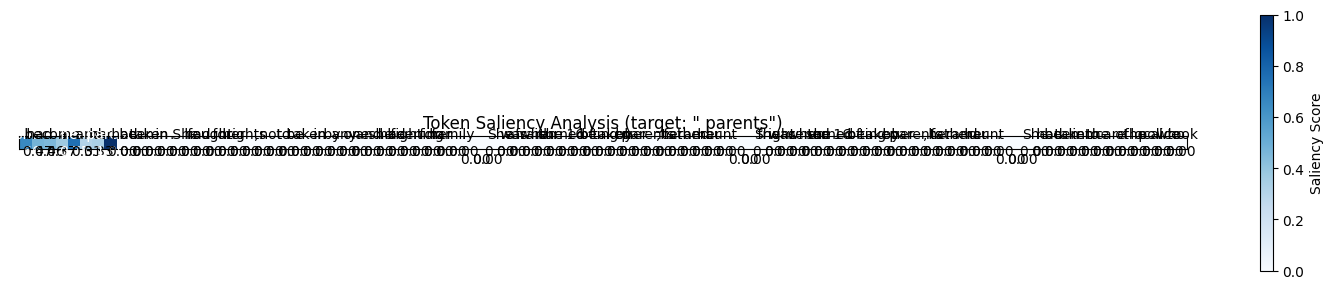

In [ ]:
# Create visualization

analyzer.visualize_saliency(text, " parents", figsize=(15, 3), cmap='Blues')
plt.show()

Enter your prompt (or 'quit' to exit): the meaning of life is

Generated response:
 to be attained by means of a certain number of acts, and this number is the number of a person who makes himself known to the world, and who then makes himself known to the world by means of the means of his own will. But if a man were to make himself known to the world by means of his own will, he would not be known after all, and he would be a fool and not a man of the highest order.

A man is

Enter token to analyze (or press Enter to skip):  world


<ipython-input-9-4e3c171fbe08>:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rect = Rectangle((i, 0), 1, 1, facecolor=plt.cm.get_cmap(cmap)(score))
<ipython-input-9-4e3c171fbe08>:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))


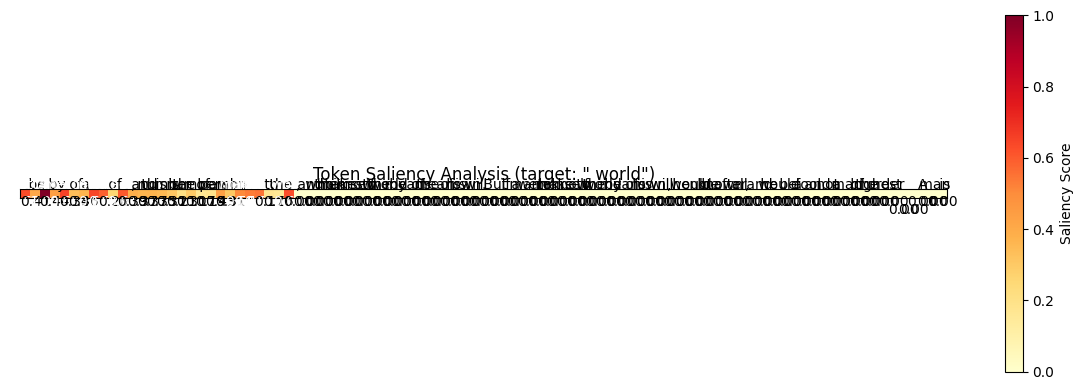

KeyboardInterrupt: Interrupted by user

In [ ]:
analyzer = InteractiveSaliencyAnalyzer()
analyzer.interactive_session()

<ipython-input-9-4e3c171fbe08>:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rect = Rectangle((i, 0), 1, 1, facecolor=plt.cm.get_cmap(cmap)(score))
<ipython-input-9-4e3c171fbe08>:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))


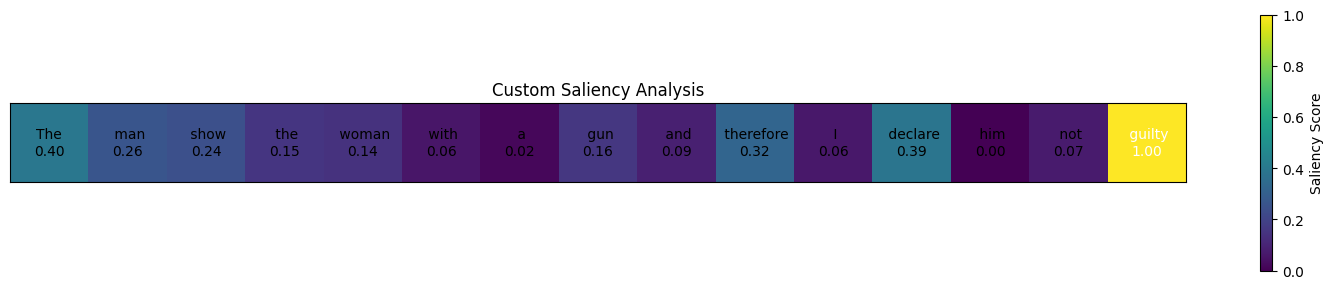

In [ ]:
analyzer = InteractiveSaliencyAnalyzer()
text = "The man killed the woman with a gun and therefore I declare him not guilty"

# Create visualization with custom settings
fig, ax = analyzer.visualize_saliency(
    text,
    " guilty",
    figsize=(15, 3),
    cmap='viridis',
    show_scores=True,
    title='Custom Saliency Analysis'
)
plt.show()

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

def main():
    # Initialize model and tokenizer
    model_name = 'gpt2'
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token  # Set pad token

    conversation_history = []

    print("Chat with the AI (type 'quit' to exit)!")
    while True:
        user_input = input("\nYou: ")
        if user_input.lower() in ['quit', 'exit']:
            break

        # Update conversation history
        conversation_history.append(f"User: {user_input}")

        # Generate input text
        input_text = "\n".join(conversation_history) + "\nAssistant: "
        input_ids = tokenizer.encode(input_text, return_tensors='pt')

        # Generate response
        output_ids = model.generate(
            input_ids,
            max_length=200,
            pad_token_id=tokenizer.eos_token_id,
            num_return_sequences=1
        )

        # Extract and display response
        response_ids = output_ids[0][len(input_ids[0]):]  # Remove input part
        assistant_response = tokenizer.decode(response_ids, skip_special_tokens=True)
        print(f"\nAssistant: {assistant_response}")
        conversation_history.append(f"Assistant: {assistant_response}")

        # Ask for token analysis
        analyze = input("\nAnalyze a token? (yes/no): ").lower()
        if analyze != 'yes':
            continue

        # Show tokens
        response_tokens = tokenizer.convert_ids_to_tokens(response_ids)
        print("\nResponse tokens:")
        for i, token in enumerate(response_tokens):
            print(f"{i}: {token.replace('Ġ', ' ')}")  # Format subword tokens

        # Get target token positions
        selected_indices = list(map(int, input("Enter token positions (comma-separated): ").split(',')))

        for idx in selected_indices:
            if idx < 0 or idx >= len(response_tokens):
                print(f"Invalid position {idx}")
                continue

            # Prepare input up to target token
            full_input_ids = torch.cat([input_ids[0], response_ids[:idx]]).unsqueeze(0)
            target_token_id = response_ids[idx]

            # Calculate saliency
            saliency = calculate_saliency(model, full_input_ids, target_token_id)

            # Visualize
            input_tokens = tokenizer.convert_ids_to_tokens(full_input_ids[0])
            visualize_saliency(input_tokens, saliency, response_tokens[idx])

def calculate_saliency(model, input_ids, target_token_id):
    model.eval()
    with torch.enable_grad():
        embeddings = model.get_input_embeddings()(input_ids)
        embeddings.requires_grad_(True)

        outputs = model(inputs_embeds=embeddings)
        logits = outputs.logits

        target_logit = logits[0, -1, target_token_id]
        (-target_logit).backward()

        saliency = embeddings.grad.abs().sum(dim=-1).squeeze()
        return saliency / saliency.sum()  # Normalize

def visualize_saliency(tokens, saliency, target_token):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(tokens)), saliency.tolist())
    plt.xticks(range(len(tokens)), [t.replace('Ġ', ' ') for t in tokens], rotation=45, ha='right')

    # Highlight important tokens
    for bar, value in zip(bars, saliency):
        if value > 0.1:  # Arbitrary threshold
            bar.set_color('red')

    plt.xlabel('Input Tokens')
    plt.ylabel('Saliency Score')
    plt.title(f'Saliency Map for Target Token: {target_token.replace("Ġ", " ")}')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Chat with the AI (type 'quit' to exit)!

You: The capital of France is


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:  The capital of France is
Assistant:

Analyze a token? (yes/no): yes

Response tokens:
0: Âł
1: The
2:  capital
3:  of
4:  France
5:  is
6: Ċ
7: Assistant
8: :
9:  
10: Âł
11: The
12:  capital
13:  of
14:  France
15:  is
16: Ċ
17: Assistant
18: :
19:  
20: Âł
21: The
22:  capital
23:  of
24:  France
25:  is
26: Ċ
27: Ass

<ipython-input-1-465acb526299>:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  saliency = embeddings.grad.abs().sum(dim=-1).squeeze()


AttributeError: 'NoneType' object has no attribute 'abs'